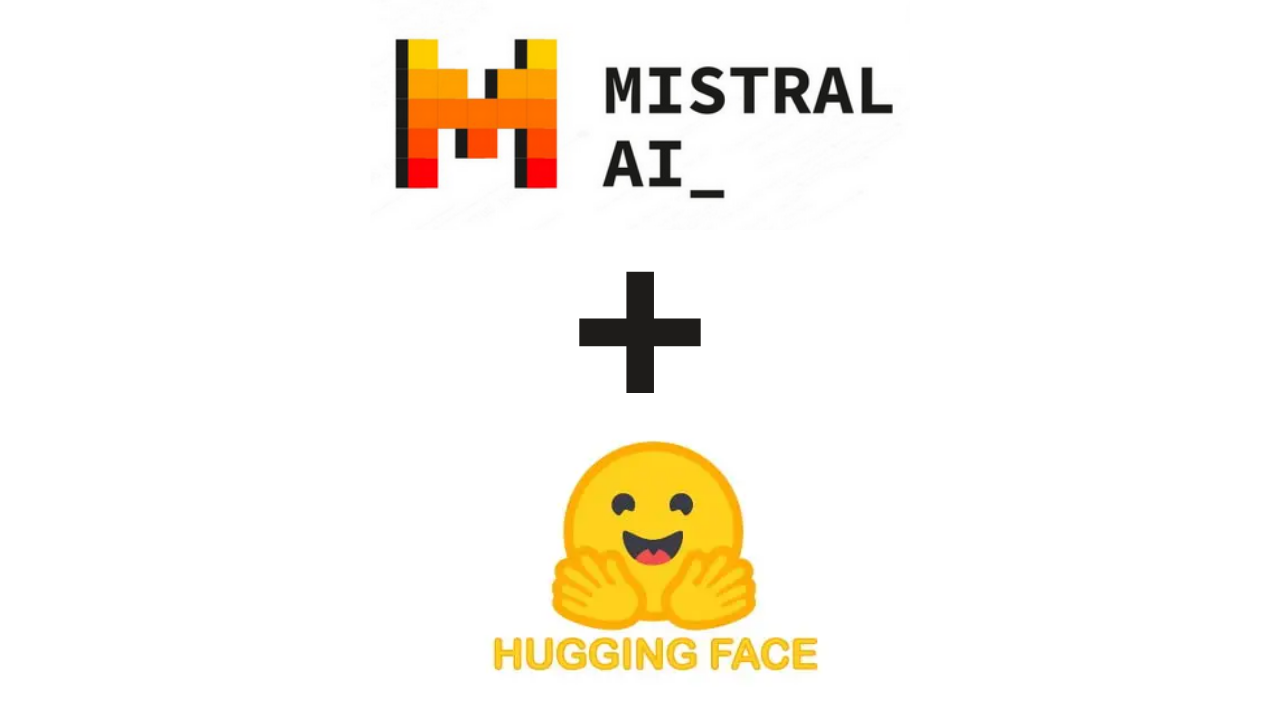

In [1]:
!pip install -q accelerate peft bitsandbytes pip install git+https://github.com/huggingface/transformers trl py7zr auto-gptq optimum

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.3/168.3 kB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.6/92.6 MB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.1/139.1 kB 19.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 66.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 403.3/403.3 kB 48.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 52.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.9/78.9 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 88.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 412.3

In [2]:
from huggingface_hub import notebook_login
notebook_login()

In [3]:
import torch
from datasets import load_dataset, Dataset
from peft import LoraConfig, AutoPeftModelForCausalLM, prepare_model_for_kbit_training, get_peft_model
from transformers import AutoModelForCausalLM, AutoTokenizer, GPTQConfig, TrainingArguments
from trl import SFTTrainer
import os

In [4]:
data = load_dataset("samsum", split="train")
data_df = data.to_pandas()
data_df["text"] = data_df[["dialogue", "summary"]].apply(lambda x: "###Human: Summarize this following dialogue: " + x["dialogue"] + "\n###Assistant: " +x["summary"], axis=1)
print(data_df.iloc[0])


Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

id                                                   13818513
dialogue    Amanda: I baked  cookies. Do you want some?\r\...
summary     Amanda baked cookies and will bring Jerry some...
text        ###Human: Summarize this following dialogue: A...
Name: 0, dtype: object


In [5]:
data = Dataset.from_pandas(data_df)
tokenizer = AutoTokenizer.from_pretrained("TheBloke/Mistral-7B-Instruct-v0.1-GPTQ")
tokenizer.pad_token = tokenizer.eos_token
quantization_config_loading = GPTQConfig(bits=4, disable_exllama=True, tokenizer=tokenizer)

model = AutoModelForCausalLM.from_pretrained(
    "TheBloke/Mistral-7B-Instruct-v0.1-GPTQ",
    quantization_config=quantization_config_loading,
    device_map="auto",
)
print(model)

tokenizer_config.json:   0%|          | 0.00/1.46k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/72.0 [00:00<?, ?B/s]

Using `disable_exllama` is deprecated and will be removed in version 4.37. Use `use_exllama` instead and specify the version with `exllama_config`.The value of `use_exllama` will be overwritten by `disable_exllama` passed in `GPTQConfig` or stored in your config file.


config.json:   0%|          | 0.00/963 [00:00<?, ?B/s]

You passed `quantization_config` to `from_pretrained` but the model you're loading already has a `quantization_config` attribute and has already quantized weights. However, loading attributes (e.g. ['use_cuda_fp16', 'use_exllama', 'max_input_length', 'exllama_config', 'disable_exllama']) will be overwritten with the one you passed to `from_pretrained`. The rest will be ignored.


model.safetensors:   0%|          | 0.00/4.16G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

MistralForCausalLM(
  (model): MistralModel(
    (embed_tokens): Embedding(32000, 4096, padding_idx=0)
    (layers): ModuleList(
      (0-31): 32 x MistralDecoderLayer(
        (self_attn): MistralAttention(
          (rotary_emb): MistralRotaryEmbedding()
          (k_proj): QuantLinear()
          (o_proj): QuantLinear()
          (q_proj): QuantLinear()
          (v_proj): QuantLinear()
        )
        (mlp): MistralMLP(
          (act_fn): SiLU()
          (down_proj): QuantLinear()
          (gate_proj): QuantLinear()
          (up_proj): QuantLinear()
        )
        (input_layernorm): MistralRMSNorm()
        (post_attention_layernorm): MistralRMSNorm()
      )
    )
    (norm): MistralRMSNorm()
  )
  (lm_head): Linear(in_features=4096, out_features=32000, bias=False)
)


In [6]:
model.config.use_cache=False
model.config.pretraining_tp=1
model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model)

peft_config = LoraConfig(
        r=16,
        lora_alpha=16,
        lora_dropout=0.05,
        bias="none",
        task_type="CAUSAL_LM",
        target_modules=["q_proj", "v_proj"],
)
model = get_peft_model(model, peft_config)

In [7]:
training_arguments = TrainingArguments(
    output_dir="mistral-finetuned-samsum",
    per_device_train_batch_size=8,
    gradient_accumulation_steps=1,
    optim="paged_adamw_32bit",
    learning_rate=2e-4,
    lr_scheduler_type="cosine",
    save_strategy="epoch",
    logging_steps=100,
    num_train_epochs=1,
    max_steps=250,
    fp16=True,
    push_to_hub=True
)

In [8]:
trainer = SFTTrainer(
    model=model,
    train_dataset=data,
    peft_config=peft_config,
    dataset_text_field="text",
    args=training_arguments,
    tokenizer=tokenizer,
    packing=False,
    max_seq_length=512
)

Map:   0%|          | 0/14732 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:282: UserWarning: You passed a tokenizer with `padding_side` not equal to `right` to the SFTTrainer. This might lead to some unexpected behaviour due to overflow issues when training a model in half-precision. You might consider adding `tokenizer.padding_side = 'right'` to your code.
  warnings.warn(


In [9]:
trainer.train()
trainer.push_to_hub()

/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss
100,1.874100
200,1.763900


adapter_model.safetensors:   0%|          | 0.00/27.3M [00:00<?, ?B/s]

events.out.tfevents.1704598985.62e9329c87fc.325.0:   0%|          | 0.00/5.70k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/4.73k [00:00<?, ?B/s]

Upload 4 LFS files:   0%|          | 0/4 [00:00<?, ?it/s]

CommitInfo(commit_url='https://huggingface.co/Anantha28/mistral-finetuned-samsum/commit/cefe350b1efe306b9f4cf47c8e06f50dd40761ca', commit_message='End of training', commit_description='', oid='cefe350b1efe306b9f4cf47c8e06f50dd40761ca', pr_url=None, pr_revision=None, pr_num=None)

In [10]:
! cp -r /content/mistral-finetuned-samsum /content/drive/MyDrive/

cp: cannot create directory '/content/drive/MyDrive/': No such file or directory


In [11]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
from peft import AutoPeftModelForCausalLM
from transformers import GenerationConfig
from transformers import AutoTokenizer
import torch
tokenizer = AutoTokenizer.from_pretrained("/content/mistral-finetuned-samsum")

inputs = tokenizer("""
###Human: Summarize this following dialogue: Vasanth: I'm at the railway station in Chennai Karthik: No problems so far? Vasanth: no, everything's going smoothly Karthik: good. lets meet there soon!
###Assistant: """, return_tensors="pt").to("cuda")

model = AutoPeftModelForCausalLM.from_pretrained(
    "/content/mistral-finetuned-samsum",
    low_cpu_mem_usage=True,
    return_dict=True,
    torch_dtype=torch.float16,
    device_map="cuda")

generation_config = GenerationConfig(
    do_sample=True,
    top_k=1,
    temperature=0.1,
    max_new_tokens=25,
    pad_token_id=tokenizer.eos_token_id
)

In [13]:

import time
st_time = time.time()
outputs = model.generate(**inputs, generation_config=generation_config)
print(tokenizer.decode(outputs[0], skip_special_tokens=True))
print(time.time()-st_time)


###Human: Summarize this following dialogue: Vasanth: I'm at the railway station in Chennai Karthik: No problems so far? Vasanth: no, everything's going smoothly Karthik: good. lets meet there soon!
###Assistant:  Vasanth is at the railway station in Chennai. Everything is going smoothly. He will meet Karthik soon.
3.426438331604004
